In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Populating the interactive namespace from numpy and matplotlib
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)


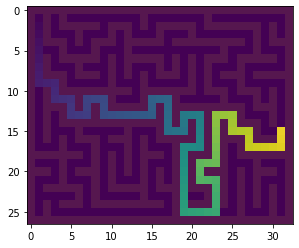

In [8]:
%pylab inline
from pandas import *
import numpy as np
from random import shuffle,randrange
from IPython.display import clear_output
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import pylab
from PIL import Image



#starting with a function to generate our maze.
def make_maze(w = 16, h = 8):
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["10"] * w + ['1'] for _ in range(h)] + [[]]
    hor = [["11"] * w + ['1'] for _ in range(h + 1)]
 
    def walk(x, y):
        vis[y][x] = 1
 
        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        for (xx, yy) in d:
            if vis[yy][xx]: continue
            if xx == x: hor[max(y, yy)][x] = "10"
            if yy == y: ver[y][max(x, xx)] = "00"
            walk(xx, yy)
 
    walk(randrange(w), randrange(h))
    
 
    s = ""
    for (a, b) in zip(hor, ver):
        s += ''.join(a + ['\n'] + b + ['\n'])
        
    M=[]
    for line in s.split("\n"):
        if line!="":
            R=[]
            for e in line:
                R.append(int(e))
            M.append(R)
    return M


#A*
#this is a node class for A* path finding parent, parent is the current node position in the maze,
#g from start to current node, h heuristic based on estimated cost from current node to n node,
#f total cost for the present node.
class Node:
    def __init__(self, parent=None,position = None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
#equality function to check the equality of the nodes when we compare it to other nodes.        
    def __eq__(self,other):
        return self.position == other.position
    
        
    
#this function returns the path of the search, it returns the value of the path.
def return_path(current_node,maze):
    path = []
    no_rows, no_columns = np.shape(maze)
    
#initiate our maze with the value -1 in every position.
    result = [[-1 for i in range(no_columns)] for j in range(no_rows)]
    current = current_node
    
    
    while current is not None:
        path.append(current.position)
        current = current.parent
        
    #return the path value in reversed so we can see the path from the start to the end.
    path = path[::-1]
    start_value = 0
    
    #then update the path value from the start to the end using A* search and every step is incremented by 1
    for i in range(len(path)):
        result[path[i][0]][path[i][1]] = start_value
        start_value += 1
    return result
    
#A* search function containing the maze, the cost, start and end values.
def search(maze, cost, start, end):
    #cteate start and end node with intiated values from variables g, h and f
    start_node = Node(None, tuple(start))
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, tuple(end))
    end_node.g = end_node.h = end_node.f = 0
    
    #two lists: yet_to_visit and visited and initialize them.
    #then we will pull out all the nodes that are yet_to_visist.
    #then finding the lowest cost node to expand next.
    #and this is the difference from A* and breadth search first, where it looks for all directions equally,
    #but A* algorithm not like that it finds the lowest path, the lowest cost, so it's measuring the cost first.
    yet_to_visit_list = []
    
    #we will pull out all nodes those already explored so that we don't explore them again.
    visited_list = []
    #add the start node.
    yet_to_visit_list.append(start_node)
    
    #adding a stop condition to avoid an infinite loop after a reasonable number of steps.
    outer_iterations = 0
    max_iterations = (len(maze) // 2) ** 10
    
    # search movement.
    #we have two axis x and y, -1 when it goes up in y axis, 1 goes down in y axis, -1 in x axis goes left.
    move = [[-1,0],#go up
            [0,-1],#go left
            [1, 0],#go down
            [0, 1]]#go right
    #getting to know how many rows and columns in the maze
    no_rows, no_columns = np.shape(maze)
    
    #loop statement so loop until we find the end.
    while len(yet_to_visit_list) > 0:
        #here every time we have any node referred from yet_to_list, put it as a counter of the limited operation.
        outer_iterations += 1
        
        #then getting the current node.
        current_node = yet_to_visit_list[0]
        current_index = 0
        for index, item in enumerate(yet_to_visit_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
            #in case we got here return the path as if there is no solution has been found or the cost is high.
        if outer_iterations > max_iterations:
            print("Too many iterations, No Path Founded!")
            return return_path(current_node,maze)
            #else pop the current node off the yet_to_visit list and add it to visited list.
        yet_to_visit_list.pop(current_index)
        visited_list.append(current_node)
        
        #test if we got our goal then return the path, if yes
        if current_node == end_node:
            return return_path(current_node,maze)
        #generating children from all adjacent squares.
        children = []
        for new_position in move:
            #getting the node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])
            #then we will check and make sure that it is within the maze boundary
            if (node_position[0] > (no_rows -1) or
                node_position[0] < 0 or
                node_position[1] > (no_columns -1) or
                node_position[1] < 0):
                continue
                
           #if statement for walkable position
            if maze[node_position[0]][node_position[1]] != 0:
                continue
        #so creates new node
            new_node = Node(current_node, node_position)
        #and appends it
            children.append(new_node)
     #loop through children
        for child in children:
            #if child in a visited list so searches the entire visited list then
            if len([visited_child for visited_child in visited_list if visited_child == child]) > 0:
                continue
                
            #then we will have the f,g,h values
            child.g = current_node.g + cost
            # then calulate the heuristic costs calculations
            child.h = (((child.position[0] - end_node.position[0]) ** 2) +
                       ((child.position[1] - end_node.position[1]) ** 2))
            child.f = child.g + child.h
            #if child is already in yet_to_visit list and g cost is already low
            if len([i for i in yet_to_visit_list if child == i and child.g > i.g]) > 0:
                continue
            #then add child to yet to visit list
            yet_to_visit_list.append(child)
            

if __name__ == '__main__':
    maze = make_maze(16,13)

    start = [1,1] #start position
    end = [15,31] #end position
    cost = 1 #cost per movement
    
    path = search(maze,cost, start, end)
    
    #imshow(maze)
    print(imshow(path))
    print(imshow(maze, alpha=0.1))
    
    
        
        
   
    
    
    
    #imshow(path)
    #path.size
    #path.shape
    #path.dtype
    #print(imshow(numpy.array(path)))
    #plt.imshow(path)
    #plt.show()
    #plt.show(path)
    
    #path.shape()


In [9]:
maze

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 [1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1],
 [1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1],
 [1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1],
 [1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1],
 [1,